In [6]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

import sys
sys.path.insert(0, '../')
import utils

In [8]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = \
    np.load('../mnist.pkl', encoding='latin1')
    
train_yo = np.zeros((train_y.shape[0], 10), dtype=np.float32)
valid_yo = np.zeros((valid_y.shape[0], 10), dtype=np.float32)
test_yo = np.zeros((test_y.shape[0], 10), dtype=np.float32)
m, nx, ny =train_x.shape[0], train_x.shape[1], train_y.max()+1
for i in range(ny):
    train_yo[train_y == i, i] = 1
    valid_yo[valid_y == i, i] = 1
    test_yo[test_y == i, i] = 1
# white_x = whiten(train_x)
min = 0.1
max = 0.9
train_x = (train_x)/(np.max(train_x)) * (max - min) + min
# train_x = train_x > 0.5
train_x = train_x.astype(np.float32)

train_yo = (train_yo)/(np.max(train_yo) ) * (max - min) + min


In [9]:
def sigmoid(x): return (1 + np.exp(-x))**-1
def sig_inv(x): return np.log(x/(1-x))

# Energy for batch examples
def E(s, W, b):
    rho_s = sigmoid(s)
    return 1./2.*s.dot(s.T) - rho_s.dot(W).dot(rho_s.T) - rho_s.dot(b)

$$ \delta = \tau - t $$
$$ a_{\tau} = \delta  $$
$$ E(s) = \frac{1}{2} \sum_{i} s_{i}^{2} - \sum_{i \neq j} w_{ij} \rho(s_{i})\rho(s_{j}) - \sum_{i} b_{i} \rho(s_{i}) $$


The continuous-time dynamics are gigven by

$$ \frac{\partial s_{i}}{\partial t} = \frac{\partial E(s_{i}) }{\partial s_{i}} = -s_{i} + \rho^{'}(s_{i}) (\sum_{j} w_{ij} \rho(s_{j}) + b_{i}) $$

The first term corresponds to the decay potential. The second term is the input from other units. 

At time, $\tau_{j}$, the jth unit with fire. Since units only communicate with binary signals, the dynamics can are rewritten. 

$$ \frac{\partial s_{i}}{\partial t} = \frac{\partial E(s_{i}) }{\partial s_{i}} = (\tau_{j} - t) ( - s_{i} + \rho^{'}(s_{i}) (b_{i}) ) + \rho^{'}(s_{i}) (w_{ij})  $$

The first term updates the potential proportional to the elapsed time and is based on the global decay and the internal bias. The second term updates the potential based on the input unit j's spike. 


In [10]:
Nx = train_x.shape[1]
Ny = train_yo.shape[1]
Ns = 256
Nt = Nx + Ny + Ns

# One layer Graph
G = np.zeros((Nt, Nt), dtype=bool)
params = [Nx, Ns, Ny]
for i in range(len(params)-1):    
    for k in range(params[i]):
        for j in range(params[i+1]):
            G[sum(params[:i]) + k, sum(params[:i+1]) + j] = 1


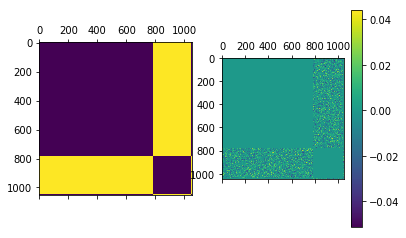

In [11]:

G = G + G.T
W = np.random.normal(0, 0.01, size=G.shape)*G
b = np.random.randn(Nt)*0.01

example = 0
fig, axes = plt.subplots(1,2)
axes[0].matshow(G)
axes[1].matshow(W)
plt.colorbar(axes[1].matshow(W), ax=axes[1])

$$ \delta = \tau - t $$
$$ a_{\tau} = \delta  $$
$$ E(s) = \frac{1}{2} \sum_{i} s_{i}^{2} - \sum_{i \neq j} w_{ij} \rho(s_{i})\rho(s_{j}) - \sum_{i} b_{i} \rho(s_{i}) $$



In [103]:
# Params
bs = 32
iterations = 1000 # Number of gradient updates
b_pos = 1. # multiplier for positive phase energy term
decay = 0.5 # Interpelation parameter [0,1]
negative_steps = 20
positive_steps = 4
lr=0.001
lr_v = 0.1

# Init Variables
vt = np.ones_like(W)
vt = np.ones_like(b)
sp_mask = np.zeros(Nt)
sp_mask[-Ny:] = 1

# Summary
# energy = []
# y_err = []
# x_err = []
# accuracy = []


for iteration in range(iterations):
    # Get samples
    samples = np.random.choice(range(train_x.shape[0]), size=bs)
    x = train_x[samples]
    y = train_yo[samples]
    
    #init states variables
    s0 = np.concatenate([sig_inv(x), np.random.normal(0, 0.01, size=(bs, Ns)), np.random.normal(0, 0.01, size=(bs, Ny))],
                        axis=1)
    rho0 = sigmoid(s0)
                         
    # Negative Phase Minimization
    s = np.copy(s0)
    
    for step in range(negative_steps):
        rho_s = sigmoid(s)
        
        # Unconstrained Gradient
        s = (1-decay)*s + decay*rho_s*(1-rho_s)*(rho_s.dot(W) + 0.*b[np.newaxis, :])
        s[:, :Nx] = s0[:, :Nx] # Fixed input
        
    s_neg = np.copy(s)
    rsn = sigmoid(s_neg)
#     rsn[:, :Nx] = x

    prediction = [np.argmax(s[:, Nx + Ns:], 1) == np.argmax(y, 1)]
    accuracy += [np.average(prediction)]
    
    
    # Positive Phase
    for step in range(positive_steps):
        rho_s = sigmoid(s)
        
        # Unconstrained Gradient        
        s = (1-decay)*s + decay*rho_s*(1-rho_s)*(rho_s.dot(W) + 0.*b[np.newaxis, :] )
        s[:, Nx + Ns:] = (1-b_pos)*s[:, Nx + Ns:] + b_pos*sig_inv(y)
        s[:, :Nx] = s0[:, :Nx] # Fixed input
        
    # Gradient Update with RMSProp
    s_pos = s
    rsp = sigmoid(s_pos)
#     rsp[:, :Nx] = x
    dw = (rsp.T.dot(rsp) - rsn.T.dot(rsn))*G / bs    
    vt = (1-lr_v)*vt + lr_v*dw**2
    dw = dw / (vt + 10**-8)**0.5
    W += lr*dw
    
#     db = rsp.mean(0) - rsn.mean(0)
#     bt = (1-lr_v)*bt + lr_v*db**2
#     db = db / (bt + 10**-8)**0.5
#     b += lr*db
    
    energy += [np.average(E(s, W, b))]
    x_err += [ np.sum((x - rsp[:, :Nx])**2, 1).mean() ]
    y_err += [ np.sum((y - sigmoid(s[:, Nx + Ns:]))**2, 1).mean() ]
    print(iteration, end='\r')
    

Text(0.5, 1.0, 'Neg Accuracy')

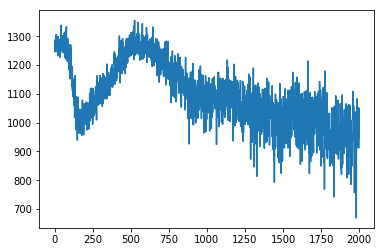

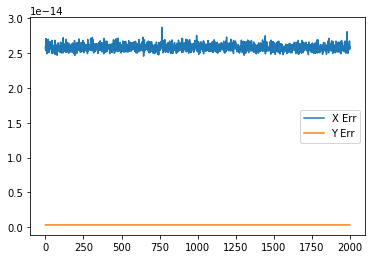

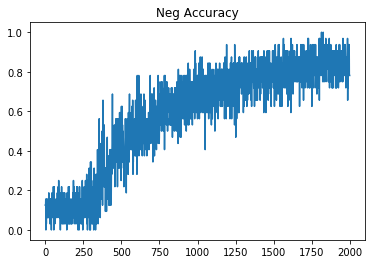

In [104]:
plt.figure()
plt.plot(energy)

plt.figure()
plt.plot( x_err, label='X Err')
plt.plot(y_err, label='Y Err')
plt.legend()

plt.figure()
plt.plot(accuracy)
plt.title('Neg Accuracy')

(array([  8.,  19.,  53., 136., 197., 255., 216., 104.,  45.,  17.]),
 array([-0.03346198, -0.02733578, -0.02120957, -0.01508337, -0.00895717,
        -0.00283096,  0.00329524,  0.00942144,  0.01554765,  0.02167385,
         0.02780005]),
 <a list of 10 Patch objects>)

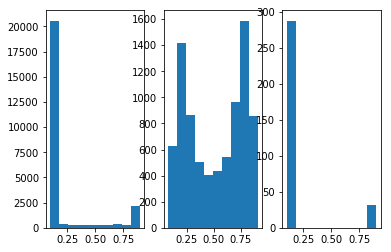

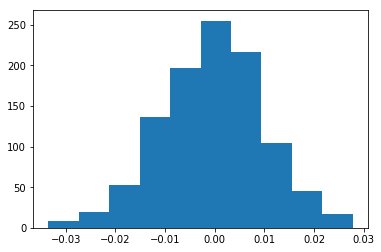

In [105]:
fig, axes = plt.subplots(1, 3)
for ax, idx in zip(axes, [range(Nx), range(Nx, Nx+Ns), range(Nx+Ns, Nx+Ns + Ny)]):
    ax.hist(rho_s[:, idx].ravel())
plt.figure()
plt.hist(b)

(array([2.00000e+02, 1.85400e+03, 9.73300e+03, 3.44840e+04, 1.57646e+05,
        8.44990e+05, 4.07060e+04, 1.08950e+04, 1.84500e+03, 1.47000e+02]),
 array([-1.19264118, -0.9561175 , -0.71959383, -0.48307016, -0.24654648,
        -0.01002281,  0.22650087,  0.46302454,  0.69954821,  0.93607189,
         1.17259556]),
 <a list of 10 Patch objects>)

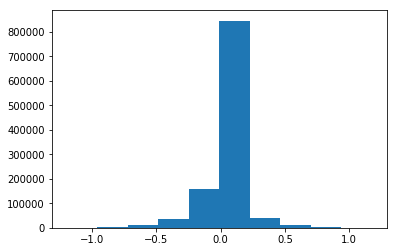

In [106]:
plt.hist(W.ravel())

(array([1.00600e+03, 5.61600e+03, 1.83660e+04, 6.51620e+04, 1.21840e+05,
        7.99052e+05, 6.61840e+04, 2.08980e+04, 3.92600e+03, 4.50000e+02]),
 array([-2.83644471, -2.29783018, -1.75921566, -1.22060114, -0.68198661,
        -0.14337209,  0.39524244,  0.93385696,  1.47247148,  2.01108601,
         2.54970053]),
 <a list of 10 Patch objects>)

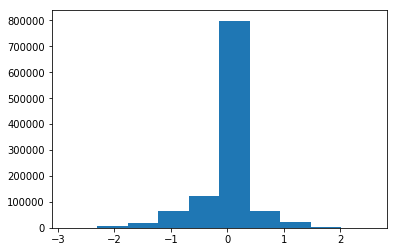

In [107]:
plt.hist(dw.ravel())

(array([1.099382e+06, 1.652000e+03, 7.400000e+02, 2.400000e+02,
        1.480000e+02, 1.220000e+02, 9.800000e+01, 7.000000e+01,
        3.200000e+01, 1.600000e+01]),
 array([1.74787125e-46, 1.32542756e-04, 2.65085513e-04, 3.97628269e-04,
        5.30171026e-04, 6.62713782e-04, 7.95256539e-04, 9.27799295e-04,
        1.06034205e-03, 1.19288481e-03, 1.32542756e-03]),
 <a list of 10 Patch objects>)

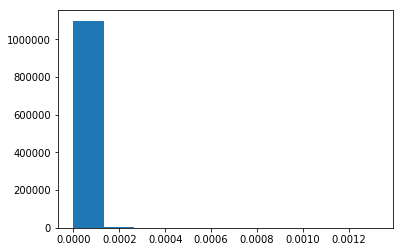

In [108]:
plt.hist(vt.ravel())

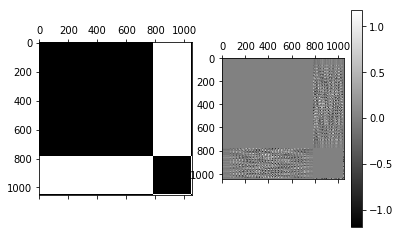

In [109]:
fig, axes = plt.subplots(1,2)
axes[0].matshow(G)
axes[1].matshow(W)
plt.colorbar(axes[1].matshow(W), ax=axes[1])

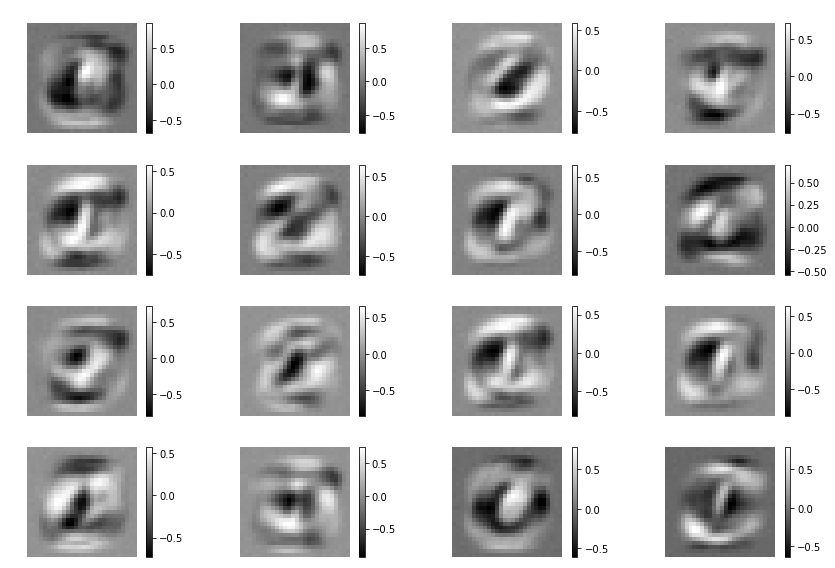

In [111]:
utils.plotmats(W[Nx:Nx + Ns, :Nx])

Sparsity Penatly

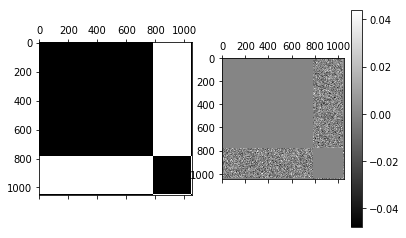

In [72]:

G = G + G.T
W = np.random.normal(0, 0.01, size=G.shape)*G
b = np.random.randn(Nt)*0.01

example = 0
fig, axes = plt.subplots(1,2)
axes[0].matshow(G)
axes[1].matshow(W)
plt.colorbar(axes[1].matshow(W), ax=axes[1])

In [73]:
# Params
bs = 32
iterations = 1000 # Number of gradient updates
b_pos = 1. # multiplier for positive phase energy term
decay = 0.5 # Interpelation parameter [0,1]
negative_steps = 20
positive_steps = 4
lr=0.01
lr_v = 0.1
lam = 0.001

# Init Variables
vt = np.ones_like(W)
vt = np.ones_like(b)
sp_mask = np.zeros(Nt)
sp_mask[-Ny:] = 1

# Summary
energy = []
y_err = []
x_err = []
accuracy = []

def st(x, l):
    return np.sign(x)*np.maximum(np.abs(x) - l, 0)

for iteration in range(iterations):
    # Get samples
    samples = np.random.choice(range(train_x.shape[0]), size=bs)
    x = train_x[samples]
    y = train_yo[samples]
    
    #init states variables
    s0 = np.concatenate([sig_inv(x), np.random.normal(0, 0.01, size=(bs, Ns)), np.random.normal(0, 0.01, size=(bs, Ny))],
                        axis=1)
    rho0 = sigmoid(s0)
                         
    # Negative Phase Minimization
    s = np.copy(s0)
#     lam = 0.1 / np.linalg.norm(W)
    for step in range(negative_steps):
        rho_s = sigmoid(s)
        
        # Unconstrained Gradient
        s = (1-decay)*s + decay*rho_s*(1-rho_s)*st(rho_s.dot(W) -lam, lam)
        s[:, :Nx] = s0[:, :Nx] # Fixed input
        
    s_neg = np.copy(s)
    rsn = sigmoid(s_neg)
#     rsn[:, :Nx] = x

    prediction = [np.argmax(s[:, Nx + Ns:], 1) == np.argmax(y, 1)]
    accuracy += [np.average(prediction)]
    
    
    # Positive Phase
    for step in range(positive_steps):
        rho_s = sigmoid(s)
        
        # Unconstrained Gradient        
        s = (1-decay)*s + decay*rho_s*(1-rho_s)*st(rho_s.dot(W) - lam, lam)
        s[:, Nx + Ns:] = (1-b_pos)*s[:, Nx + Ns:] + b_pos*sig_inv(y)
        s[:, :Nx] = s0[:, :Nx] # Fixed input
        
    # Gradient Update with RMSProp
    s_pos = s
    rsp = sigmoid(s_pos)
#     rsp[:, :Nx] = x
    dw = (rsp.T.dot(rsp) - rsn.T.dot(rsn))*G / bs    
    vt = (1-lr_v)*vt + lr_v*dw**2
    dw = dw / (vt + 10**-8)**0.5
    W += lr*dw
    
#     db = rsp.mean(0) - rsn.mean(0)
#     bt = (1-lr_v)*bt + lr_v*db**2
#     db = db / (bt + 10**-8)**0.5
#     b += lr*db
    
    energy += [np.average(E(s, W, b))]
    x_err += [ np.sum((x - rsp[:, :Nx])**2, 1).mean() ]
    y_err += [ np.sum((y - sigmoid(s[:, Nx + Ns:]))**2, 1).mean() ]
    print(iteration, end='\r')
    

Text(0.5, 1.0, 'Neg Accuracy')

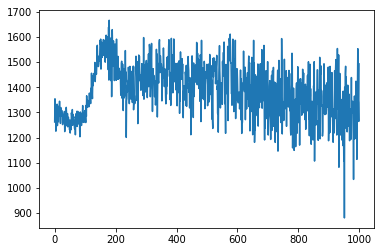

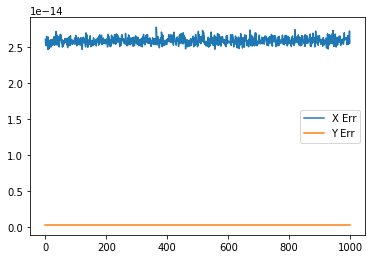

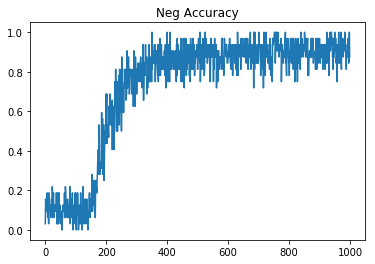

In [74]:
plt.figure()
plt.plot(energy)

plt.figure()
plt.plot( x_err, label='X Err')
plt.plot(y_err, label='Y Err')
plt.legend()

plt.figure()
plt.plot(accuracy)
plt.title('Neg Accuracy')

(array([  7.,  31.,  90., 187., 227., 242., 168.,  72.,  22.,   4.]),
 array([-0.0277329 , -0.02194058, -0.01614826, -0.01035594, -0.00456362,
         0.0012287 ,  0.00702102,  0.01281334,  0.01860566,  0.02439798,
         0.0301903 ]),
 <a list of 10 Patch objects>)

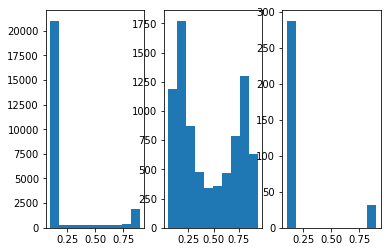

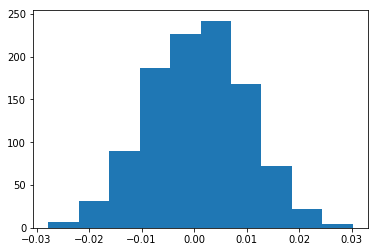

In [75]:
fig, axes = plt.subplots(1, 3)
for ax, idx in zip(axes, [range(Nx), range(Nx, Nx+Ns), range(Nx+Ns, Nx+Ns + Ny)]):
    ax.hist(rho_s[:, idx].ravel())
plt.figure()
plt.hist(b)

(array([5.40000e+01, 3.51000e+02, 2.61100e+03, 1.67310e+04, 1.10071e+05,
        9.18813e+05, 4.59090e+04, 7.39900e+03, 5.21000e+02, 4.00000e+01]),
 array([-2.76584898, -2.24484645, -1.72384392, -1.20284138, -0.68183885,
        -0.16083632,  0.36016621,  0.88116875,  1.40217128,  1.92317381,
         2.44417634]),
 <a list of 10 Patch objects>)

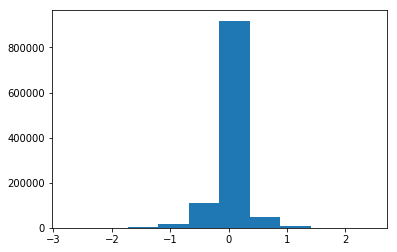

In [76]:
plt.hist(W.ravel())

(array([  4042.,  16608.,  37188.,  71972., 103750., 786990.,  50674.,
         22500.,   6730.,   2046.]),
 array([-3.11278603, -2.49287111, -1.87295619, -1.25304128, -0.63312636,
        -0.01321144,  0.60670348,  1.2266184 ,  1.84653331,  2.46644823,
         3.08636315]),
 <a list of 10 Patch objects>)

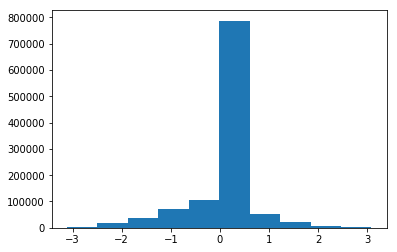

In [77]:
plt.hist(dw.ravel())

(array([1.099522e+06, 1.096000e+03, 7.080000e+02, 3.700000e+02,
        2.500000e+02, 1.840000e+02, 1.600000e+02, 1.380000e+02,
        5.400000e+01, 1.800000e+01]),
 array([1.74787125e-46, 5.01650060e-05, 1.00330012e-04, 1.50495018e-04,
        2.00660024e-04, 2.50825030e-04, 3.00990036e-04, 3.51155042e-04,
        4.01320048e-04, 4.51485054e-04, 5.01650060e-04]),
 <a list of 10 Patch objects>)

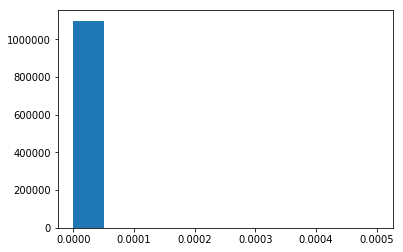

In [78]:
plt.hist(vt.ravel())

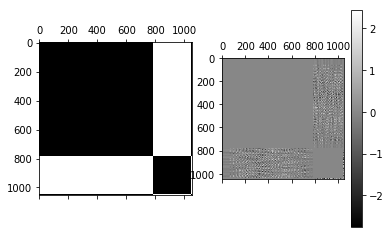

In [79]:
fig, axes = plt.subplots(1,2)
axes[0].matshow(G)
axes[1].matshow(W)
plt.colorbar(axes[1].matshow(W), ax=axes[1])

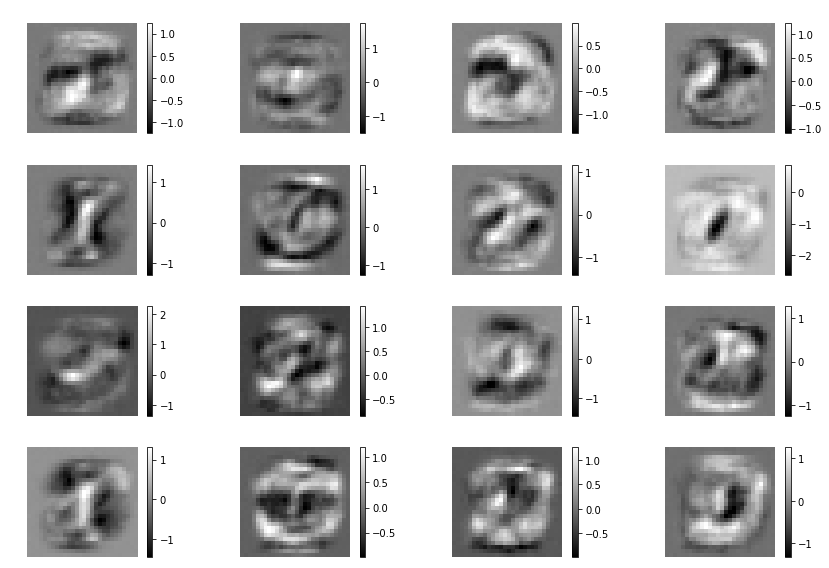

In [80]:
utils.plotmats(W[Nx:Nx + Ns, :Nx])